# Tutorial: Understanding Y = A × K × B

**The Linear Perturbation Prediction Model**

This tutorial provides an intuitive walkthrough of the linear perturbation prediction model:

**Y = A × K × B**

We will explore each variable (Y, A, K, B) in detail:
1. **Origin**: Where does each variable come from?
2. **Processing steps**: How is it transformed?
3. **Final form**: What does it look like at the end?
4. **Matrix multiplication**: How do they combine?

By the end, you'll have a deep intuition for how this model works and why it's effective for predicting gene expression changes.


## Overview of the Model

The linear perturbation prediction model uses matrix factorization to predict how genes respond to perturbations:

**Y ≈ A × K × B + center**

Where:
- **Y** (genes × perturbations): Observed expression changes
- **A** (genes × d): Gene embeddings (low-dimensional representation of genes)
- **K** (d × d): Interaction matrix (learned parameters via ridge regression)
- **B** (d × perturbations): Perturbation embeddings (low-dimensional representation of perturbations)
- **center** (genes × 1): Row means of training data (added back during prediction)
- **d**: Embedding dimension (typically 10)

**Key insight**: Instead of directly learning how each gene responds to each perturbation (which would require ~8,000 genes × ~200 perturbations = 1.6M parameters), we compress this into:
- Gene structure (A): ~8,000 × 10 = 80K parameters
- Perturbation structure (B): ~10 × 200 = 2K parameters  
- Interaction (K): ~10 × 10 = 100 parameters
- **Total: ~82K parameters** (20× reduction!)

This compression works because genes and perturbations have structure that can be captured in low dimensions.

### Note on Notation

In the original Nature Methods 2025 paper, this is written as:

**Ŷ = G W Pᵀ + b**

Where:
- **G** = A (gene embeddings)
- **W** = K (interaction matrix)
- **Pᵀ** = B (perturbation embeddings, transposed)
- **b** = center (row means of training data)

The formulas are **identical**—only the variable names differ! Our implementation (Y = A × K × B + center) matches the paper's methodology exactly.


In [1]:
# Setup and imports
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata as ad
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
import warnings
warnings.filterwarnings('ignore')

# Set up paths
NOTEBOOK_DIR = Path.cwd()
EVAL_FRAMEWORK_DIR = NOTEBOOK_DIR.parent if NOTEBOOK_DIR.name == "tutorials" else NOTEBOOK_DIR
if NOTEBOOK_DIR.name == "tutorials":
    sys.path.insert(0, str(EVAL_FRAMEWORK_DIR / "src"))

# Import helper functions
from goal_2_baselines.baseline_runner import compute_pseudobulk_expression_changes
from shared.linear_model import solve_y_axb

# Set random seed for reproducibility
np.random.seed(42)

print("✅ Setup complete!")


✅ Setup complete!


## Part 1: The Y Matrix - Expression Changes

### Origin

**Y** comes from single-cell RNA sequencing (scRNA-seq) data. We start with:
- **Raw data**: Count matrix (cells × genes) with expression levels
- **Perturbation labels**: Each cell is labeled with its perturbation condition
- **Control cells**: Baseline cells without any perturbation

### Processing Steps

1. **Aggregate cells by condition** → Pseudobulk expression
2. **Compute mean expression** per gene per condition
3. **Subtract control baseline** → Change from baseline

### Final Form

**Y** is a matrix of **expression changes**:
- **Rows**: Genes (~8,000-10,000 genes)
- **Columns**: Perturbations (~100-300 perturbations)
- **Values**: Change in expression from control baseline

**Formula**: 
$$Y_{i,j} = \text{mean}(gene_i \text{ in pert}_j) - \text{mean}(gene_i \text{ in control})$$


Y Matrix (Expression Changes)
Shape: (50, 10) = (genes × perturbations)

First 5 genes, first 5 perturbations:
        Pert_1  Pert_2  Pert_3  Pert_4  Pert_5
Gene_1    1.13   -0.45    1.57    2.81   -0.51
Gene_2   -0.79   -1.11    0.76   -4.07   -3.49
Gene_3    3.07   -0.63    0.41   -3.09   -1.13
Gene_4   -1.06    3.53    0.25   -2.36    1.61
Gene_5    1.62    0.17    0.05   -0.84   -3.00


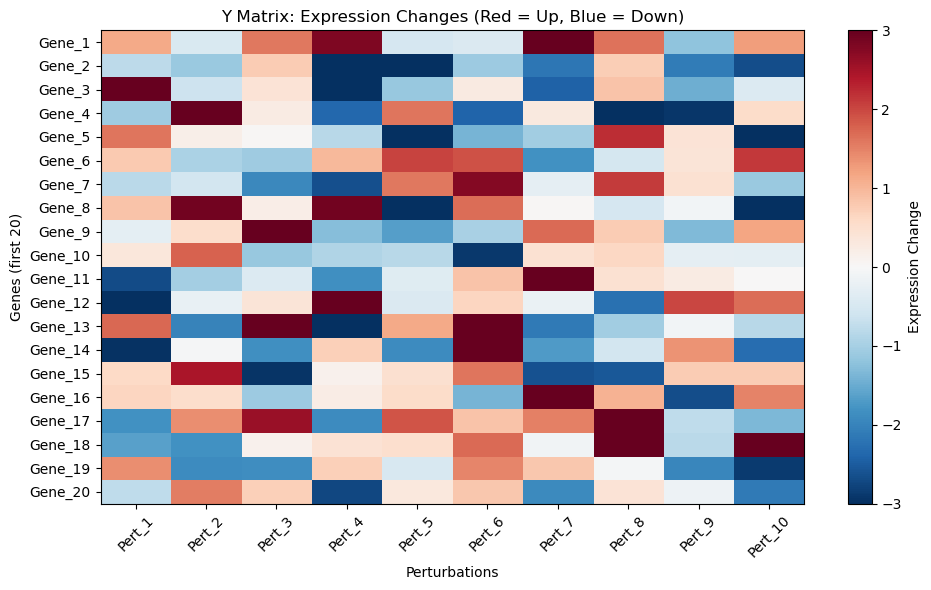


✅ Y matrix represents HOW MUCH each gene changes in response to each perturbation


In [2]:
# Create synthetic Y matrix to illustrate the concept
n_genes = 50  # Small example for visualization
n_perturbations = 10

# Simulate Y matrix: expression changes from control
# In reality, this comes from pseudobulk analysis of scRNA-seq data
Y = np.random.randn(n_genes, n_perturbations) * 2
Y = Y - Y.mean(axis=0)  # Center each perturbation

# Create gene and perturbation names
gene_names = [f"Gene_{i+1}" for i in range(n_genes)]
pert_names = [f"Pert_{i+1}" for i in range(n_perturbations)]

Y_df = pd.DataFrame(Y, index=gene_names, columns=pert_names)

print("Y Matrix (Expression Changes)")
print(f"Shape: {Y.shape} = (genes × perturbations)")
print(f"\nFirst 5 genes, first 5 perturbations:")
print(Y_df.iloc[:5, :5].round(2))

# Visualize Y matrix
plt.figure(figsize=(10, 6))
plt.imshow(Y[:20, :], aspect='auto', cmap='RdBu_r', vmin=-3, vmax=3)
plt.colorbar(label='Expression Change')
plt.xlabel('Perturbations')
plt.ylabel('Genes (first 20)')
plt.title('Y Matrix: Expression Changes (Red = Up, Blue = Down)')
plt.xticks(range(n_perturbations), pert_names, rotation=45)
plt.yticks(range(min(20, n_genes)), gene_names[:20])
plt.tight_layout()
plt.show()

print("\n✅ Y matrix represents HOW MUCH each gene changes in response to each perturbation")


## Part 2: The A Matrix - Gene Embeddings

### Origin

**A** (gene embeddings) captures the **structure of genes** in a low-dimensional space. There are several ways to create gene embeddings:

1. **PCA on training data** (Self-trained): Learn gene structure from observed responses
2. **Pre-trained models** (scGPT, scFoundation): Use knowledge from large-scale models
3. **Random**: Baseline control (no structure)

### Processing Steps

For **PCA-based embeddings** (most common):
1. Start with **Y_train** (genes × train_perturbations)
2. Treat each **gene as an observation**, perturbations as features
3. Apply **PCA** to find the top d principal components
4. Each gene gets a d-dimensional embedding vector

### Final Form

**A** is a matrix of **gene embeddings**:
- **Rows**: Genes (~8,000-10,000)
- **Columns**: Embedding dimensions (d = 10)
- **Values**: Coordinates of each gene in the embedding space

**Physical meaning**: Genes with similar embeddings respond similarly to perturbations.

**Research finding**: Our EPIC2 mechanism ablation study demonstrated that PCA embeddings capture functional relationships (co-regulation, pathways, etc.) better than deep learning embeddings. When same-class neighbors are removed from LSFT, PCA shows a large performance drop, indicating strong biological structure in the embedding space. See `publication_package/EPIC2_MECHANISM_ABLATION_REPORT.md` for details.


Step 1: Y_train (genes × train_perturbations)
Shape: (50, 7)
First 5 genes, first 5 train perturbations:
        Pert_1  Pert_2  Pert_3  Pert_4  Pert_5
Gene_1    1.13   -0.45    1.57    2.81   -0.51
Gene_2   -0.79   -1.11    0.76   -4.07   -3.49
Gene_3    3.07   -0.63    0.41   -3.09   -1.13
Gene_4   -1.06    3.53    0.25   -2.36    1.61
Gene_5    1.62    0.17    0.05   -0.84   -3.00

Step 2: Apply PCA to get A (gene embeddings)
A shape: (50, 5) = (genes × 5)

First 10 genes' embeddings:
           PC1    PC2    PC3    PC4    PC5
Gene_1   2.516  2.667  0.212 -1.975  1.259
Gene_2  -2.030 -0.945 -3.407 -0.985 -1.999
Gene_3  -3.364 -1.388 -2.709 -1.200 -1.549
Gene_4  -1.374  1.821  1.860  1.815 -3.742
Gene_5  -0.209  0.550 -3.270 -0.149 -1.428
Gene_6  -1.042 -2.262  1.010  0.770  1.890
Gene_7  -1.547 -3.562  0.808  0.083 -0.223
Gene_8   1.508  2.859 -5.171  2.114  2.030
Gene_9  -0.526  3.069 -0.845 -2.158 -0.851
Gene_10  0.939  1.018 -0.553  1.133 -3.264


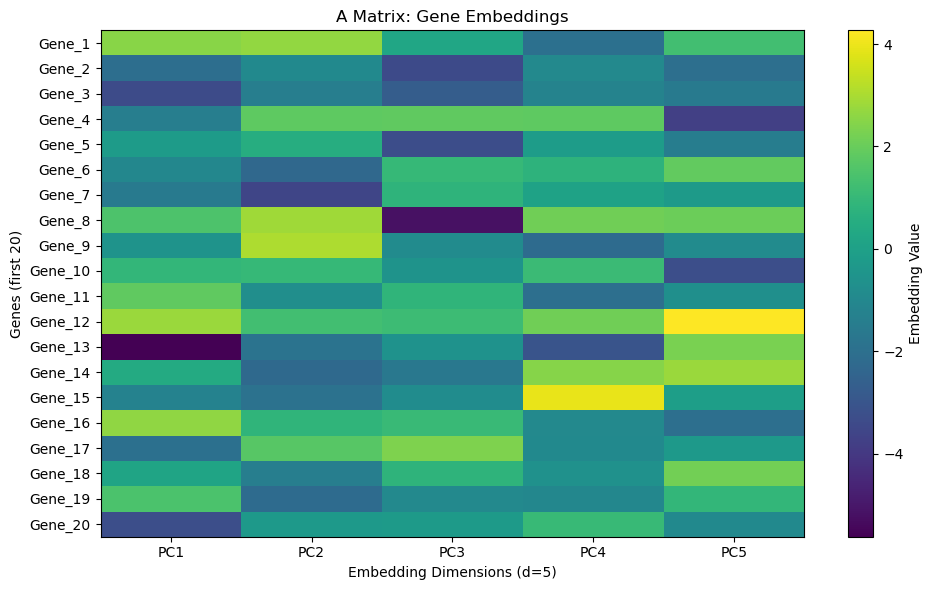

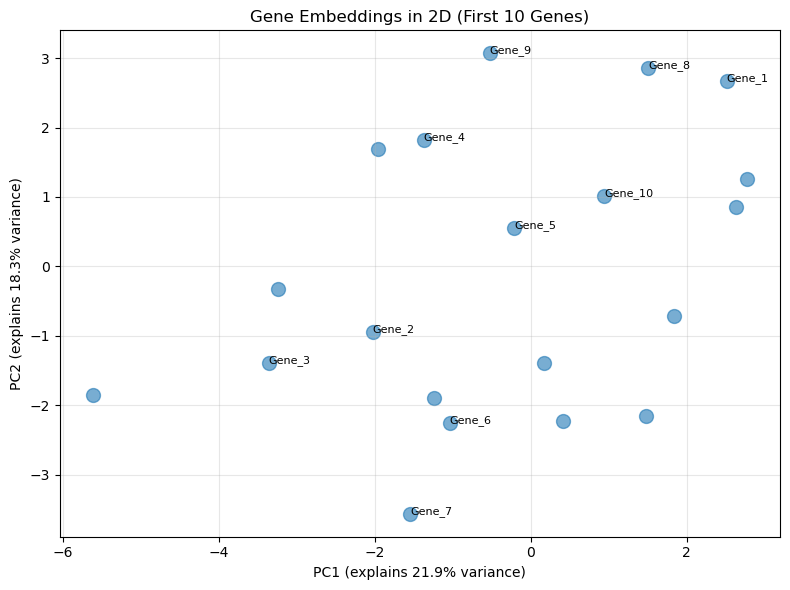


✅ A matrix represents WHERE each gene lives in the 5-dimensional embedding space
   Genes with similar embeddings will respond similarly to perturbations


In [3]:
# Create A matrix using PCA on training data
d = 5  # Embedding dimension (smaller for visualization)

# Split Y into train and test
train_perts = pert_names[:7]  # Use first 7 perturbations for training
test_perts = pert_names[7:]   # Remaining 3 for testing

Y_train = Y_df[train_perts].values  # genes × train_perturbations

print("Step 1: Y_train (genes × train_perturbations)")
print(f"Shape: {Y_train.shape}")
print(f"First 5 genes, first 5 train perturbations:")
print(pd.DataFrame(Y_train[:5, :5], index=gene_names[:5], columns=train_perts[:5]).round(2))

# Step 2: Apply PCA
# PCA treats genes as observations, perturbations as features
pca = PCA(n_components=d, random_state=42)
A = pca.fit_transform(Y_train)  # genes × d

print(f"\nStep 2: Apply PCA to get A (gene embeddings)")
print(f"A shape: {A.shape} = (genes × {d})")
print(f"\nFirst 10 genes' embeddings:")
A_df = pd.DataFrame(A[:10, :], index=gene_names[:10], 
                    columns=[f"PC{i+1}" for i in range(d)])
print(A_df.round(3))

# Visualize A matrix
plt.figure(figsize=(10, 6))
plt.imshow(A[:20, :], aspect='auto', cmap='viridis')
plt.colorbar(label='Embedding Value')
plt.xlabel(f'Embedding Dimensions (d={d})')
plt.ylabel('Genes (first 20)')
plt.title('A Matrix: Gene Embeddings')
plt.xticks(range(d), [f'PC{i+1}' for i in range(d)])
plt.yticks(range(min(20, n_genes)), gene_names[:20])
plt.tight_layout()
plt.show()

# Visualize 2D projection of gene embeddings
plt.figure(figsize=(8, 6))
plt.scatter(A[:20, 0], A[:20, 1], s=100, alpha=0.6)
for i in range(min(10, n_genes)):
    plt.annotate(gene_names[i], (A[i, 0], A[i, 1]), fontsize=8)
plt.xlabel(f'PC1 (explains {pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 (explains {pca.explained_variance_ratio_[1]:.1%} variance)')
plt.title('Gene Embeddings in 2D (First 10 Genes)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✅ A matrix represents WHERE each gene lives in the {d}-dimensional embedding space")
print(f"   Genes with similar embeddings will respond similarly to perturbations")


## Part 3: The B Matrix - Perturbation Embeddings

### Origin

**B** (perturbation embeddings) captures the **structure of perturbations** in a low-dimensional space. Similar to A, there are several methods:

1. **PCA on training data** (Self-trained): Learn perturbation structure from observed responses
2. **Pre-trained models** (GEARS): Use embeddings from perturbation prediction models
3. **Dataset-specific** (K562 PCA, RPE1 PCA): Learn from specific cell types
4. **Random**: Baseline control (no structure)

### Processing Steps

For **PCA-based embeddings**:
1. Start with **Y_train** (genes × train_perturbations) - same as A!
2. Treat each **perturbation as an observation**, genes as features
3. Apply **PCA** to find the top d principal components
4. Each perturbation gets a d-dimensional embedding vector
5. **Transpose** to get d × perturbations format

### Final Form

**B** is a matrix of **perturbation embeddings**:
- **Rows**: Embedding dimensions (d = 10)
- **Columns**: Perturbations (~100-300)
- **Values**: Coordinates of each perturbation in the embedding space

**Physical meaning**: Perturbations with similar embeddings affect similar genes.

**Research finding**: EPIC2 mechanism ablation demonstrated that PCA embeddings group perturbations by functional class. Removing same-class neighbors from LSFT causes large performance drops for PCA but not for deep learning models, showing PCA captures biological structure (pathways, mechanisms, etc.) better. See `publication_package/EPIC2_MECHANISM_ABLATION_REPORT.md` for details.


In [ ]:
# Create B matrix using PCA on training data
# Note: We use the SAME Y_train, but transpose the perspective

print("Step 1: Y_train (genes × train_perturbations)")
print(f"Shape: {Y_train.shape}")

# Step 2: Apply PCA to perturbations
# Now treat perturbations as observations, genes as features
pca_pert = PCA(n_components=d, random_state=42)
pert_embeddings = pca_pert.fit_transform(Y_train.T)  # perturbations × d

print(f"\nStep 2: Apply PCA to perturbations")
print(f"pert_embeddings shape: {pert_embeddings.shape} = (train_perturbations × {d})")

# Step 3: Transpose to get B format (d × perturbations)
B_train = pert_embeddings.T  # d × train_perturbations

print(f"\nStep 3: Transpose to get B (perturbation embeddings)")
print(f"B_train shape: {B_train.shape} = ({d} × train_perturbations)")
print(f"\nB matrix (all {d} dimensions for all train perturbations):")
B_df = pd.DataFrame(B_train, 
                    index=[f"PC{i+1}" for i in range(d)],
                    columns=train_perts)
print(B_df.round(3))

# Visualize B matrix
plt.figure(figsize=(10, 6))
plt.imshow(B_train, aspect='auto', cmap='plasma')
plt.colorbar(label='Embedding Value')
plt.xlabel('Train Perturbations')
plt.ylabel(f'Embedding Dimensions (d={d})')
plt.title('B Matrix: Perturbation Embeddings')
plt.xticks(range(len(train_perts)), train_perts, rotation=45)
plt.yticks(range(d), [f'PC{i+1}' for i in range(d)])
plt.tight_layout()
plt.show()

# Visualize 2D projection of perturbation embeddings
plt.figure(figsize=(8, 6))
plt.scatter(B_train[0, :], B_train[1, :], s=200, alpha=0.6, c=range(len(train_perts)), cmap='viridis')
for i, pert in enumerate(train_perts):
    plt.annotate(pert, (B_train[0, i], B_train[1, i]), fontsize=9)
plt.xlabel(f'PC1 (explains {pca_pert.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'PC2 (explains {pca_pert.explained_variance_ratio_[1]:.1%} variance)')
plt.title('Perturbation Embeddings in 2D')
plt.colorbar(label='Perturbation Index')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✅ B matrix represents WHERE each perturbation lives in the {d}-dimensional embedding space")
print(f"   Perturbations with similar embeddings affect similar sets of genes")


## Part 4: The K Matrix - Interaction Matrix

### Origin

**K** is **learned from data** using ridge regression. It's not constructed from raw data like A, B, or Y—it's the **parameter we solve for**.

### Processing Steps

1. Start with **Y_train**, **A**, and **B_train** (all from training data)
2. Use **ridge regression** to solve: Y = A × K × B
3. Add **regularization** (ridge penalty λ) to prevent overfitting

### Mathematical Solution

The ridge regression solution for **K**:

$$K = (A^T A + \lambda I)^{-1} A^T (Y - b) B^T (B B^T + \lambda I)^{-1}$$

Where:
- **b**: Row means of training data (center): `b = mean(Y, axis=1)`
- **Y - b**: Centered Y matrix (row means subtracted)
- **λ**: Ridge penalty (typically 0.1)
- **I**: Identity matrix

**Note**: This matches the paper's Equation 3 exactly:
- Paper: $W = (G^T G + \lambda I)^{-1} G^T (Y_{train} - b) P (P^T P + \lambda I)^{-1}$
- Our: $K = (A^T A + \lambda I)^{-1} A^T (Y - b) B^T (B B^T + \lambda I)^{-1}$
- Since $B = P^T$ and $A = G$, they're identical!

**Intuition**: K learns how gene embeddings (A) and perturbation embeddings (B) interact to produce expression changes (Y).

### Final Form

**K** is a matrix of **interaction weights**:
- **Rows**: Gene embedding dimensions (d = 10)
- **Columns**: Perturbation embedding dimensions (d = 10)
- **Values**: How much each gene embedding dimension interacts with each perturbation embedding dimension


In [ ]:
# Solve for K using ridge regression
ridge_penalty = 0.1

# Convert Y_train to numpy array
Y_train_array = Y_train  # genes × train_perturbations

print("Inputs to ridge regression:")
print(f"  Y_train: {Y_train_array.shape} (genes × train_perturbations)")
print(f"  A: {A.shape} (genes × {d})")
print(f"  B_train: {B_train.shape} ({d} × train_perturbations)")

# Step 1: Center Y (subtract row means) - This is 'b' in the paper
center = Y_train_array.mean(axis=1, keepdims=True)  # genes × 1
Y_centered = Y_train_array - center  # Y - b

print(f"\nStep 1: Center Y (subtract row means)")
print(f"  center (b): {center.shape} = row means of Y_train")
print(f"  Y_centered: {Y_centered.shape} = Y_train - center")
print(f"  First 5 row means: {center[:5, 0].round(3)}")

# Use the solve_y_axb function (handles ridge regression)
# Note: solve_y_axb handles centering internally, but we show it explicitly here
result = solve_y_axb(
    Y=Y_train_array,  # Function will center internally
    A=A,
    B=B_train,
    ridge_penalty=ridge_penalty
)

K = result["K"]

# Verify centering matches
center_from_function = result.get("center")
if center_from_function is not None:
    print(f"\n✅ Centering verified: Function computed center correctly")

print(f"\n✅ Solved for K!")
print(f"K shape: {K.shape} = ({d} × {d})")
print(f"\nK matrix (interaction weights):")
K_df = pd.DataFrame(K, 
                    index=[f"Gene_emb_{i+1}" for i in range(d)],
                    columns=[f"Pert_emb_{i+1}" for i in range(d)])
print(K_df.round(3))

# Visualize K matrix
plt.figure(figsize=(8, 6))
plt.imshow(K, aspect='auto', cmap='RdBu_r', vmin=-K.max(), vmax=K.max())
plt.colorbar(label='Interaction Weight')
plt.xlabel('Perturbation Embedding Dimensions')
plt.ylabel('Gene Embedding Dimensions')
plt.title('K Matrix: Interaction Weights')
plt.xticks(range(d), [f'Pert_emb_{i+1}' for i in range(d)])
plt.yticks(range(d), [f'Gene_emb_{i+1}' for i in range(d)])
plt.tight_layout()
plt.show()

print("\n✅ K matrix represents HOW gene embeddings and perturbation embeddings interact")
print(f"   Each value K[i,j] tells us how much gene dimension i responds to perturbation dimension j")


## Part 5: Matrix Multiplication - How It All Fits Together

Now let's see how **Y = A × K × B + center** works step by step.

### Step-by-Step Matrix Multiplication

1. **First multiplication**: **A × K**
   - Shape: (genes × d) × (d × d) = (genes × d)
   - Meaning: Transform gene embeddings through the interaction matrix

2. **Second multiplication**: **(A × K) × B**
   - Shape: (genes × d) × (d × perturbations) = (genes × perturbations)
   - Meaning: Apply perturbation embeddings to get predicted expression changes

3. **Add center**: **(A × K × B) + center**
   - Shape: (genes × perturbations) + (genes × 1) = (genes × perturbations)
   - Meaning: Add back row means to match the original Y scale

### Dimension Check

- **Y**: (genes × perturbations) ✓
- **A**: (genes × d) ✓
- **K**: (d × d) ✓
- **B**: (d × perturbations) ✓
- **center**: (genes × 1) ✓

**Verification**: genes × d × d × perturbations + genes × 1 = genes × perturbations ✓

**Note**: The center is computed as `center = Y_train.mean(axis=1, keepdims=True)` (row means) and is added back during prediction to match the original scale of Y.

Let's see this in action!


In [ ]:
# Matrix multiplication: Y_pred = A × K × B

print("=" * 70)
print("MATRIX MULTIPLICATION: Y = A × K × B")
print("=" * 70)

# Step 1: A × K
print("\nStep 1: A × K")
print(f"  A: {A.shape} (genes × {d})")
print(f"  K: {K.shape} ({d} × {d})")
AK = A @ K  # genes × d
print(f"  → AK: {AK.shape} (genes × {d})")
print(f"  ✅ First {min(3, n_genes)} rows of AK:")
print(pd.DataFrame(AK[:3, :], index=gene_names[:3], 
                   columns=[f"Transformed_{i+1}" for i in range(d)]).round(3))

# Step 2: (A × K) × B + center
print("\nStep 2: (A × K) × B + center")
print(f"  AK: {AK.shape} (genes × {d})")
print(f"  B_train: {B_train.shape} ({d} × train_perturbations)")
print(f"  center: {center.shape} (genes × 1)")
Y_pred = AK @ B_train + center  # genes × train_perturbations
print(f"  → Y_pred: {Y_pred.shape} (genes × train_perturbations)")
print(f"  ✅ Predicted Y matches original Y_train shape!")
print(f"  ✅ Note: We add center back to match the original Y scale")

# Compare predicted vs actual
print("\n" + "=" * 70)
print("COMPARISON: Predicted vs Actual Y_train")
print("=" * 70)

print(f"\nFirst 5 genes, first 5 train perturbations:")
comparison_df = pd.DataFrame({
    'Actual': Y_train[:5, 0],
    'Predicted': Y_pred[:5, 0]
}, index=gene_names[:5])
comparison_df['Difference'] = comparison_df['Actual'] - comparison_df['Predicted']
comparison_df['Abs_Error'] = np.abs(comparison_df['Difference'])
print(comparison_df.round(3))

# Compute overall error
mse = np.mean((Y_train - Y_pred)**2)
correlation = np.corrcoef(Y_train.flatten(), Y_pred.flatten())[0, 1]

print(f"\nModel Performance:")
print(f"  Mean Squared Error (MSE): {mse:.4f}")
print(f"  Correlation: {correlation:.4f}")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Actual Y_train
im1 = axes[0].imshow(Y_train[:20, :], aspect='auto', cmap='RdBu_r', vmin=-3, vmax=3)
axes[0].set_title('Actual Y_train')
axes[0].set_xlabel('Train Perturbations')
axes[0].set_ylabel('Genes (first 20)')
plt.colorbar(im1, ax=axes[0], label='Expression Change')

# Predicted Y_pred
im2 = axes[1].imshow(Y_pred[:20, :], aspect='auto', cmap='RdBu_r', vmin=-3, vmax=3)
axes[1].set_title('Predicted Y_pred = A × K × B + center')
axes[1].set_xlabel('Train Perturbations')
axes[1].set_ylabel('Genes (first 20)')
plt.colorbar(im2, ax=axes[1], label='Expression Change')

plt.tight_layout()
plt.show()

# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(Y_train.flatten(), Y_pred.flatten(), alpha=0.5, s=20)
plt.plot([Y_train.min(), Y_train.max()], [Y_train.min(), Y_train.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Y_train')
plt.ylabel('Predicted Y_pred')
plt.title(f'Prediction Accuracy (r={correlation:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ Matrix multiplication Y = A × K × B + center successfully reconstructs Y_train!")
print(f"   The model learns how gene structure (A) and perturbation structure (B)")
print(f"   interact (via K) to produce expression changes (Y)")
print(f"   Note: Center is added back to match the original Y scale")


## Part 6: Making Predictions on New Perturbations

Once we've learned **K** from training data, we can predict expression changes for **new perturbations**!

### Key Steps

1. **Transform new perturbation into embedding space**: Use the same PCA model to get **B_test**
2. **Apply the learned K**: Use **Y_pred = A × K × B_test + center**
3. **Result**: Predictions for all genes in the new perturbation

### Important Note

The **A** and **K** matrices remain fixed (learned from training data). Only **B_test** changes for each new perturbation.

**Note on center**: We add the **center** (row means from training data) back to the prediction to match the original Y scale. This is because:
- During training, we center Y: `Y_centered = Y - center`
- We solve for K using the centered data: `Y_centered = A @ K @ B_train`
- During prediction, we add center back: `Y_pred = A @ K @ B_test + center`


In [ ]:
# Make predictions on test perturbations

print("=" * 70)
print("PREDICTING ON NEW PERTURBATIONS")
print("=" * 70)

# Get test data
Y_test = Y_df[test_perts].values  # genes × test_perturbations

print(f"\nTest perturbations: {test_perts}")
print(f"Y_test shape: {Y_test.shape} (genes × test_perturbations)")

# Transform test perturbations into embedding space using the SAME PCA model
# This is crucial: we use the PCA model fitted on training data
pert_emb_test = pca_pert.transform(Y_test.T)  # test_perturbations × d
B_test = pert_emb_test.T  # d × test_perturbations

print(f"\nStep 1: Transform test perturbations using trained PCA")
print(f"B_test shape: {B_test.shape} ({d} × test_perturbations)")

# Step 2: Predict using learned K + center
print(f"\nStep 2: Predict using Y_pred = A × K × B_test + center")
print(f"  Note: We add center back to match the original Y scale")
Y_test_pred = (A @ K) @ B_test + center  # genes × test_perturbations

print(f"Y_test_pred shape: {Y_test_pred.shape} (genes × test_perturbations)")

# Compare predictions
print(f"\nComparison for first test perturbation ({test_perts[0]}):")
comparison_test = pd.DataFrame({
    'Actual': Y_test[:10, 0],
    'Predicted': Y_test_pred[:10, 0]
}, index=gene_names[:10])
comparison_test['Difference'] = comparison_test['Actual'] - comparison_test['Predicted']
print(comparison_test.round(3))

# Compute performance
mse_test = np.mean((Y_test - Y_test_pred)**2)
correlation_test = np.corrcoef(Y_test.flatten(), Y_test_pred.flatten())[0, 1]

print(f"\nTest Performance:")
print(f"  Mean Squared Error (MSE): {mse_test:.4f}")
print(f"  Correlation: {correlation_test:.4f}")

# Visualize predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

im1 = axes[0].imshow(Y_test[:20, :], aspect='auto', cmap='RdBu_r', vmin=-3, vmax=3)
axes[0].set_title('Actual Y_test')
axes[0].set_xlabel('Test Perturbations')
axes[0].set_ylabel('Genes (first 20)')
plt.colorbar(im1, ax=axes[0], label='Expression Change')

im2 = axes[1].imshow(Y_test_pred[:20, :], aspect='auto', cmap='RdBu_r', vmin=-3, vmax=3)
axes[1].set_title('Predicted Y_test_pred = A × K × B_test + center')
axes[1].set_xlabel('Test Perturbations')
axes[1].set_ylabel('Genes (first 20)')
plt.colorbar(im2, ax=axes[1], label='Expression Change')

plt.tight_layout()
plt.show()

# Scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(Y_test.flatten(), Y_test_pred.flatten(), alpha=0.5, s=20)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 
         'r--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual Y_test')
plt.ylabel('Predicted Y_test_pred')
plt.title(f'Test Prediction Accuracy (r={correlation_test:.3f})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✅ Successfully predicted expression changes for new perturbations!")
print(f"   We use the SAME A and K (learned from training)")
print(f"   and transform new perturbations into the embedding space (B_test)")
print(f"   We add center back to match the original Y scale: Y_pred = A × K × B_test + center")


## Summary: Building Intuition for Y = A × K × B

### Key Takeaways

1. **Y (Expression Changes)**: The observed data we want to predict
   - Origin: scRNA-seq data → pseudobulk → change from control
   - Shape: genes × perturbations
   - Represents: How much each gene changes in each perturbation

2. **A (Gene Embeddings)**: Low-dimensional representation of genes
   - Origin: PCA on training data (or pre-trained models)
   - Shape: genes × d (typically d=10)
   - Represents: Where each gene lives in embedding space
   - **Key insight**: Genes with similar embeddings respond similarly
   - **Research finding**: EPIC2 mechanism ablation showed PCA embeddings capture functional relationships (co-regulation, pathways) better than deep learning embeddings (see `publication_package/EPIC2_MECHANISM_ABLATION_REPORT.md`)

3. **B (Perturbation Embeddings)**: Low-dimensional representation of perturbations
   - Origin: PCA on training data (or pre-trained models)
   - Shape: d × perturbations
   - Represents: Where each perturbation lives in embedding space
   - **Key insight**: Perturbations with similar embeddings affect similar genes

4. **K (Interaction Matrix)**: Learned parameters connecting A and B
   - Origin: Solved via ridge regression from training data
   - Shape: d × d (typically 10×10)
   - Represents: How gene embeddings and perturbation embeddings interact
   - **Key insight**: K learns the interaction patterns from data

### Why This Works

- **Dimensionality reduction**: Instead of learning genes × perturbations directly (~1.6M parameters), we learn compressed representations (~82K parameters)
- **Structure capture**: A and B capture meaningful structure. **Research finding**: EPIC2 showed PCA embeddings preserve functional relationships (co-regulation, pathways, mechanisms) better than deep learning embeddings (see `publication_package/EPIC2_MECHANISM_ABLATION_REPORT.md`)
- **Transfer learning**: Once K is learned, we can predict on new perturbations by just transforming them to embedding space (B_test)

### The Magic Formula

**Y ≈ A × K × B + center**

This simple matrix multiplication elegantly captures how:
- Gene structure (A) interacts with
- Perturbation structure (B) via
- Learned interactions (K) to produce
- Expression changes (Y)
- With center added back to match the original scale

**Note**: During training, we solve `Y_centered = A @ K @ B_train` where `Y_centered = Y - center`. 
During prediction, we add center back: `Y_pred = A @ K @ B_test + center`.

**Congratulations!** You now have a deep understanding of the linear perturbation prediction model! 🎉
